In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pyl
import os
import re
import imageio

import plotly.express as px

## Define a class to deal with the results

In [2]:
class TRIDYN_simulation:
    def __init__(self, file_retained = "", file_profiles = "",aantalincomming = 1,fractions = [1],elementen = []):
        self.file_retained = file_retained
        self.file_profiles = file_profiles
        self.fluence_vals = 0
        self.retained_vals = 0
        self.retained_calc = 0
        self.depth_vals = 0
        self.concentration_vals_implanted = 0
        self.concentration_vals_substrate = 0
        self.surface_density = 0
        self.aantalincomming = aantalincomming
        self.fractions = fractions
        self.elementen = elementen        
        
    def print_filenames(self):
        if (self.file_retained != ""):
            print("retained amount is located at " + self.file_retained + "\n")
        if (self.file_profiles != ""):
            print("Depth profiles is located at " + self.file_profiles + "\n")
            
            
    def load_retained(self):
        if (self.file_retained != ""):
            with open(self.file_retained) as f:
                lines = f.readlines()
            tebekijk = (lines[-1])
            counter = 0
            colspecs = []
            tuple1 = 0
            tuple2 = 0
            inwoord = False
            for ii in tebekijk:
                if not ii.isspace():
                    if not inwoord:
                        inwoord = True
                        tuple1 = counter
                else: #wel een spatie
                    if inwoord == True: #je zat in een woord en dus is het einde bereikt
                        tuple2 = counter
                        inwoord = False
                if tuple1!=0 and tuple2!=0:
                    colspecs.append((tuple1,tuple2))
                    tuple1 = 0
                    tuple2 = 0        
                counter+=1
            #print(colspecs)      

            simulation = np.array(pd.read_fwf(self.file_retained, colspecs=colspecs, header=1).T) #areal density
            self.fluence_vals = simulation[0]
            self.retained_vals = []
            for ii in range(self.aantalincomming):
                self.retained_vals.append(simulation[2+ii])
        else:
            print("No ardn file selected")
            self.fluence_vals = np.zeros(100)
            self.retained_vals = np.zeros(100)
      
    
    def load_profiles(self):
        if (self.file_profiles != ""):        
            ls_files = os.listdir(path=self.file_profiles)
            
            dirfile = path + profiles + ls_files[0]
            with open(dirfile) as f:
                lines = f.readlines()
            tebekijk = (lines[-1])
            counter = 0
            colspecs = []
            tuple1 = 0
            tuple2 = 0
            inwoord = False
            for ii in tebekijk:
                if not ii.isspace():
                    if not inwoord:
                        inwoord = True
                        tuple1 = counter
                else: #wel een spatie
                    if inwoord == True: #je zat in een woord en dus is het einde bereikt
                        tuple2 = counter
                        inwoord = False
                if tuple1!=0 and tuple2!=0:
                    colspecs.append((tuple1,tuple2))
                    tuple1 = 0
                    tuple2 = 0        
                counter+=1
            #print(colspecs)
                        
            self.depth_vals = []
            self.surface_density = []
            self.concentration_vals_substrate = []
            self.concentration_vals_implanted = []
            
            
            for i in range(len(ls_files)):
                directory_file = self.file_profiles + ls_files[i]
                
                single_profile = np.array(pd.read_fwf(directory_file, colspecs = colspecs, header=4).T)
                
                for i in range(len(single_profile[2])):
                    for jj in range(self.aantalincomming+1):
                        single_profile[jj+2][i] = np.float64(str(single_profile[jj+2][i]).rstrip("-").lstrip("-"))
                        #single_profile[2][i] = np.float64(str(single_profile[2][i]).rstrip("-").lstrip("-"))
                        #single_profile[3][i] = np.float64(str(single_profile[3][i]).rstrip("-").lstrip("-"))
                
                #print(single_profile[2])
                
                self.depth_vals.append(single_profile[0])
                self.surface_density.append(single_profile[1])
                self.concentration_vals_substrate.append(single_profile[2])
                toetevoegen = []
                for jj in range(self.aantalincomming):
                    toetevoegen.append(single_profile[jj+3])
                self.concentration_vals_implanted.append(toetevoegen)
        
        else:
            print("No depth profile files selected")
            self.depth_vals = np.zeros((100, 100))
            self.surface_density = np.zeros((100, 100))
            self.concentration_vals_substrate = np.zeros((100, 100))
            self.concentration_vals_implanted = np.zeros((100, 100))
        
        
    def calc_retained(self, start_depth=0, end_depth=10**6):
        del_depth = self.depth_vals[0][1] - self.depth_vals[0][0]
        max_depth = self.depth_vals[0][-1] + del_depth/2
        self.retained_calc = []
        for ii in range(self.aantalincomming):
            self.retained_calc.append(np.zeros(len(self.retained_vals[0])))
        self.retained_calc = np.array(self.retained_calc)
        
        for i in range(len(self.depth_vals)):  #0 tot 100          
            acc = np.zeros(self.aantalincomming)
            
            for j in range(len(self.depth_vals[0])): #0 tot diepte   
                if ((self.depth_vals[0][j] > start_depth) and (self.depth_vals[0][j] < end_depth)):
                    #print((self.concentration_vals_implanted)[i])
                    for jj in range(self.aantalincomming):
                        acc[jj] += del_depth * np.array(self.concentration_vals_implanted)[i][jj][j] * self.surface_density[i][j]
            
            self.retained_calc[:,i] = acc        
        
        
    def load(self):
        self.load_retained()
        self.load_profiles()
    
    
    def draw_retained(self, **kwargs):
        for jj in range(self.aantalincomming):
            plt.plot(self.fluence_vals*self.fractions[jj], self.retained_vals[jj])
        plt.xlabel("Implantation fluence scaled for the fraction ($\AA ^{-2}$)")
        plt.ylabel("Retained fluence ($\AA ^{-2}$)")
        plt.legend(self.elementen)
        plt.grid()
        
    def draw_retained_Tb(self, **kwargs):
        jj=0
        plt.plot(self.fluence_vals*self.fractions[jj], self.retained_vals[jj])
        plt.xlabel("Implantation fluence scaled for the fraction ($\AA ^{-2}$)")
        plt.ylabel("Retained fluence for Tb ($\AA ^{-2}$)")
        plt.grid()
        
        
    def draw_lost(self, **kwargs):
        for jj in range(self.aantalincomming):
            plt.plot(self.fluence_vals*self.fractions[jj], self.fluence_vals*self.fractions[jj] - self.retained_vals[jj])
        plt.xlabel("Implantation fluence scaled for the fraction ($\AA ^{-2}$)")
        plt.ylabel("Lost fluence ($\AA ^{-2}$)")
        plt.legend(self.elementen)
        plt.grid()
        
    
    def draw_calc_retained(self, **kwargs):
        for jj in range(self.aantalincomming):
            plt.plot(self.fluence_vals*self.fractions[jj], np.array(self.retained_calc)[jj], "--")
        plt.xlabel("Implantation fluence scaled for the fraction ($\AA ^{-2}$)")
        plt.ylabel("Retained fluence ($\AA ^{-2}$)")
        plt.legend(self.elementen)
        plt.grid()
        
        
    def draw_profile(self, index, bool_implant, **kwargs):
        if bool_implant:
            for jj in range(self.aantalincomming):
                plt.plot(self.depth_vals[index], self.concentration_vals_implanted[index][jj])
            plt.legend(self.elementen)
        else:
            plt.plot(self.depth_vals[index], self.concentration_vals_substrate[index])
        
        plt.xlabel("Depth ($\AA$)")
        plt.ylabel("Concentration (%)")
        plt.grid()
        
        
    def draw_3d(self, **kwargs):
        X = self.depth_vals[0]
        Y = self.fluence_vals
        for jj in range(self.aantalincomming):
            print(jj)
            Y = self.fluence_vals*self.fractions[jj]
            K, L = np.meshgrid(X, Y)
            Z = np.array(self.concentration_vals_implanted)[:,jj]
            if jj == 1:
                im = pyl.pcolormesh(K, L, Z, shading='auto', vmin=0, vmax=0.19)
            if jj==0:
                im = pyl.pcolormesh(K, L, Z, shading='auto', vmin=0, vmax=0.3)
            cbar = plt.colorbar(im,orientation='vertical')
            plt.xlabel("Depth ($\AA$)")
            plt.ylabel("Fluence ($\AA ^{-2}$)")
            plt.title(self.elementen[jj])
            cbar.set_label("Atomic concentration (%)")
            plt.show()
        

In [5]:
allenamen = ['Tbna_000_0.in',
 'Tbna_000_1.in',
 'Tbna_000_2.in',
 'Tbna_000_3.in',
 'Tbna_000_4.in',
 'Tbna_000_5.in',
 'Tbna_000_6.in',
 'Tbna_000_7.in',
 'Tbna_000_8.in',
 'Tbna_000_9.in',
 'Tbna_001_0.in',
 'Tbna_001_1.in',
 'Tbna_001_2.in',
 'Tbna_001_3.in',
 'Tbna_001_4.in',
 'Tbna_001_5.in',
 'Tbna_001_6.in',
 'Tbna_001_7.in',
 'Tbna_001_8.in',
 'Tbna_001_9.in',
 'Tbna_031_0.in',
 'Tbna_031_1.in',
 'Tbna_031_2.in',
 'Tbna_031_3.in',
 'Tbna_031_4.in',
 'Tbna_031_5.in',
 'Tbna_031_6.in',
 'Tbna_031_7.in',
 'Tbna_031_8.in',
 'Tbna_031_9.in',
 'Tbna_051_0.in',
 'Tbna_051_1.in',
 'Tbna_051_2.in',
 'Tbna_051_3.in',
 'Tbna_051_4.in',
 'Tbna_051_5.in',
 'Tbna_051_6.in',
 'Tbna_051_7.in',
 'Tbna_051_8.in',
 'Tbna_051_9.in',
 'Tbna_072_0.in',
 'Tbna_072_1.in',
 'Tbna_072_2.in',
 'Tbna_072_3.in',
 'Tbna_072_4.in',
 'Tbna_072_5.in',
 'Tbna_072_6.in',
 'Tbna_072_7.in',
 'Tbna_072_8.in',
 'Tbna_072_9.in',
 'Tbna_092_0.in',
 'Tbna_092_1.in',
 'Tbna_092_2.in',
 'Tbna_092_3.in',
 'Tbna_092_4.in',
 'Tbna_092_5.in',
 'Tbna_092_6.in',
 'Tbna_092_7.in',
 'Tbna_092_8.in',
 'Tbna_092_9.in',
 'Tbna_113_0.in',
 'Tbna_113_1.in',
 'Tbna_113_2.in',
 'Tbna_113_3.in',
 'Tbna_113_4.in',
 'Tbna_113_5.in',
 'Tbna_113_6.in',
 'Tbna_113_7.in',
 'Tbna_113_8.in',
 'Tbna_113_9.in',
 'Tbna_133_0.in',
 'Tbna_133_1.in',
 'Tbna_133_2.in',
 'Tbna_133_3.in',
 'Tbna_133_4.in',
 'Tbna_133_5.in',
 'Tbna_133_6.in',
 'Tbna_133_7.in',
 'Tbna_133_8.in',
 'Tbna_133_9.in',
 'Tbna_154_0.in',
 'Tbna_154_1.in',
 'Tbna_154_2.in',
 'Tbna_154_3.in',
 'Tbna_154_4.in',
 'Tbna_154_5.in',
 'Tbna_154_6.in',
 'Tbna_154_7.in',
 'Tbna_154_8.in',
 'Tbna_154_9.in',
 'Tbna_174_0.in',
 'Tbna_174_1.in',
 'Tbna_174_2.in',
 'Tbna_174_3.in',
 'Tbna_174_4.in',
 'Tbna_174_5.in',
 'Tbna_174_6.in',
 'Tbna_174_7.in',
 'Tbna_174_8.in',
 'Tbna_174_9.in',
 'Tbna_195_0.in',
 'Tbna_195_1.in',
 'Tbna_195_2.in',
 'Tbna_195_3.in',
 'Tbna_195_4.in',
 'Tbna_195_5.in',
 'Tbna_195_6.in',
 'Tbna_195_7.in',
 'Tbna_195_8.in',
 'Tbna_195_9.in',
 'Tbna_215_0.in',
 'Tbna_215_1.in',
 'Tbna_215_2.in',
 'Tbna_215_3.in',
 'Tbna_215_4.in',
 'Tbna_215_5.in',
 'Tbna_215_6.in',
 'Tbna_215_7.in',
 'Tbna_215_8.in',
 'Tbna_215_9.in',
 'Tbna_236_0.in',
 'Tbna_236_1.in',
 'Tbna_236_2.in',
 'Tbna_236_3.in',
 'Tbna_236_4.in',
 'Tbna_236_5.in',
 'Tbna_236_6.in',
 'Tbna_236_7.in',
 'Tbna_236_8.in',
 'Tbna_236_9.in',
 'Tbna_256_0.in',
 'Tbna_256_1.in',
 'Tbna_256_2.in',
 'Tbna_256_3.in',
 'Tbna_256_4.in',
 'Tbna_256_5.in',
 'Tbna_256_6.in',
 'Tbna_256_7.in',
 'Tbna_256_8.in',
 'Tbna_256_9.in',
 'Tbna_277_0.in',
 'Tbna_277_1.in',
 'Tbna_277_2.in',
 'Tbna_277_3.in',
 'Tbna_277_4.in',
 'Tbna_277_5.in',
 'Tbna_277_6.in',
 'Tbna_277_7.in',
 'Tbna_277_8.in',
 'Tbna_277_9.in',
 'Tbna_297_0.in',
 'Tbna_297_1.in',
 'Tbna_297_2.in',
 'Tbna_297_3.in',
 'Tbna_297_4.in',
 'Tbna_297_5.in',
 'Tbna_297_6.in',
 'Tbna_297_7.in',
 'Tbna_297_8.in',
 'Tbna_297_9.in',
 'Tbna_318_0.in',
 'Tbna_318_1.in',
 'Tbna_318_2.in',
 'Tbna_318_3.in',
 'Tbna_318_4.in',
 'Tbna_318_5.in',
 'Tbna_318_6.in',
 'Tbna_318_7.in',
 'Tbna_318_8.in',
 'Tbna_318_9.in',
 'Tbna_338_0.in',
 'Tbna_338_1.in',
 'Tbna_338_2.in',
 'Tbna_338_3.in',
 'Tbna_338_4.in',
 'Tbna_338_5.in',
 'Tbna_338_6.in',
 'Tbna_338_7.in',
 'Tbna_338_8.in',
 'Tbna_338_9.in',
 'Tbna_359_0.in',
 'Tbna_359_1.in',
 'Tbna_359_2.in',
 'Tbna_359_3.in',
 'Tbna_359_4.in',
 'Tbna_359_5.in',
 'Tbna_359_6.in',
 'Tbna_359_7.in',
 'Tbna_359_8.in',
 'Tbna_359_9.in',
 'Tbna_379_0.in',
 'Tbna_379_1.in',
 'Tbna_379_2.in',
 'Tbna_379_3.in',
 'Tbna_379_4.in',
 'Tbna_379_5.in',
 'Tbna_379_6.in',
 'Tbna_379_7.in',
 'Tbna_379_8.in',
 'Tbna_379_9.in',
 'Tbna_400_0.in',
 'Tbna_400_1.in',
 'Tbna_400_2.in',
 'Tbna_400_3.in',
 'Tbna_400_4.in',
 'Tbna_400_5.in',
 'Tbna_400_6.in',
 'Tbna_400_7.in',
 'Tbna_400_8.in',
 'Tbna_400_9.in']

In [6]:
incfluenceTbtot = 2

['Tbna_000_0.in', 'Tbna_000_1.in', 'Tbna_000_2.in', 'Tbna_000_3.in', 'Tbna_000_4.in', 'Tbna_000_5.in', 'Tbna_000_6.in', 'Tbna_000_7.in', 'Tbna_000_8.in', 'Tbna_000_9.in']
0


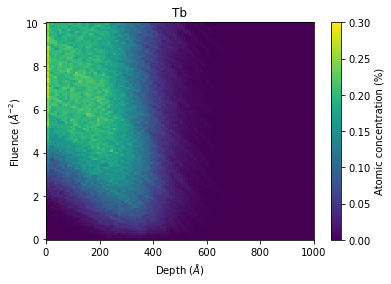

1


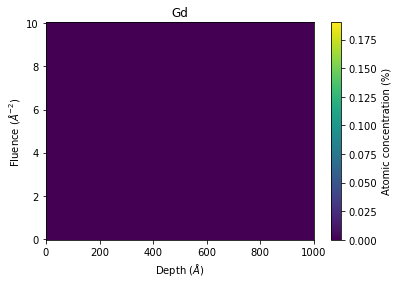

['Tbna_001_0.in', 'Tbna_001_1.in', 'Tbna_001_2.in', 'Tbna_001_3.in', 'Tbna_001_4.in', 'Tbna_001_5.in', 'Tbna_001_6.in', 'Tbna_001_7.in', 'Tbna_001_8.in', 'Tbna_001_9.in']
0


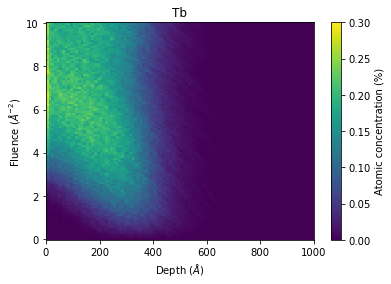

1


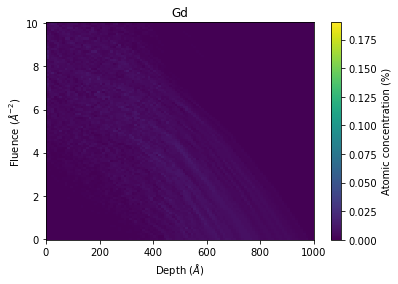

['Tbna_031_0.in', 'Tbna_031_1.in', 'Tbna_031_2.in', 'Tbna_031_3.in', 'Tbna_031_4.in', 'Tbna_031_5.in', 'Tbna_031_6.in', 'Tbna_031_7.in', 'Tbna_031_8.in', 'Tbna_031_9.in']
0


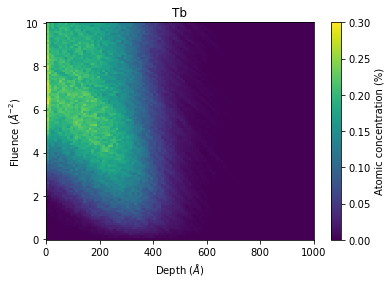

1


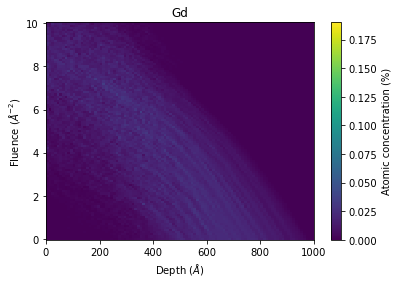

['Tbna_051_0.in', 'Tbna_051_1.in', 'Tbna_051_2.in', 'Tbna_051_3.in', 'Tbna_051_4.in', 'Tbna_051_5.in', 'Tbna_051_6.in', 'Tbna_051_7.in', 'Tbna_051_8.in', 'Tbna_051_9.in']
0


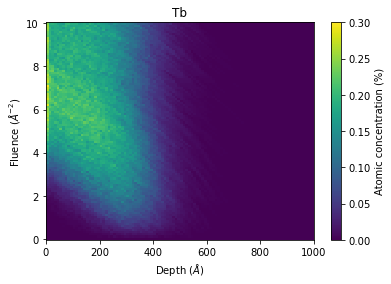

1


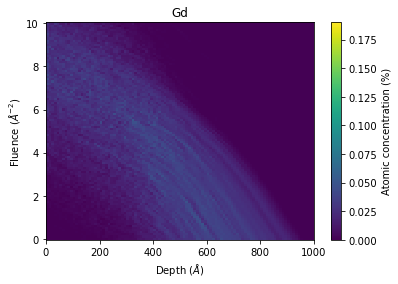

['Tbna_072_0.in', 'Tbna_072_1.in', 'Tbna_072_2.in', 'Tbna_072_3.in', 'Tbna_072_4.in', 'Tbna_072_5.in', 'Tbna_072_6.in', 'Tbna_072_7.in', 'Tbna_072_8.in', 'Tbna_072_9.in']
0


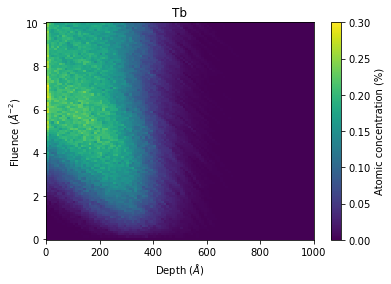

1


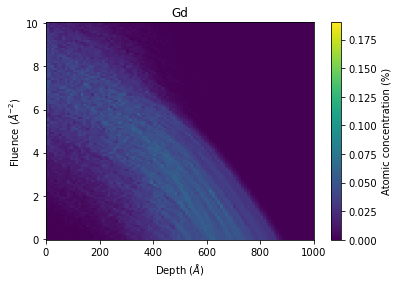

['Tbna_092_0.in', 'Tbna_092_1.in', 'Tbna_092_2.in', 'Tbna_092_3.in', 'Tbna_092_4.in', 'Tbna_092_5.in', 'Tbna_092_6.in', 'Tbna_092_7.in', 'Tbna_092_8.in', 'Tbna_092_9.in']
0


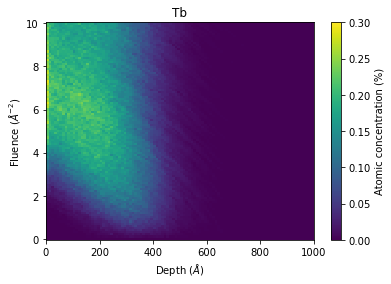

1


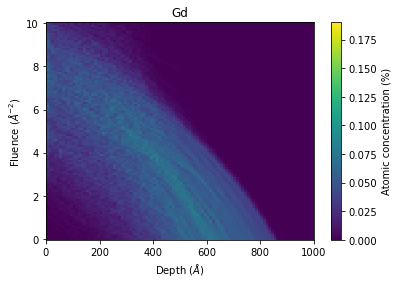

['Tbna_113_0.in', 'Tbna_113_1.in', 'Tbna_113_2.in', 'Tbna_113_3.in', 'Tbna_113_4.in', 'Tbna_113_5.in', 'Tbna_113_6.in', 'Tbna_113_7.in', 'Tbna_113_8.in', 'Tbna_113_9.in']
0


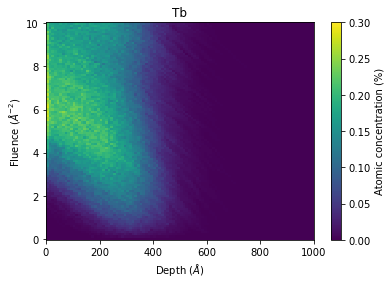

1


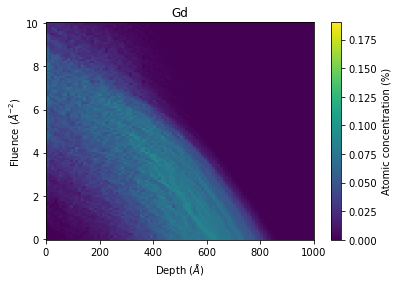

['Tbna_133_0.in', 'Tbna_133_1.in', 'Tbna_133_2.in', 'Tbna_133_3.in', 'Tbna_133_4.in', 'Tbna_133_5.in', 'Tbna_133_6.in', 'Tbna_133_7.in', 'Tbna_133_8.in', 'Tbna_133_9.in']
0


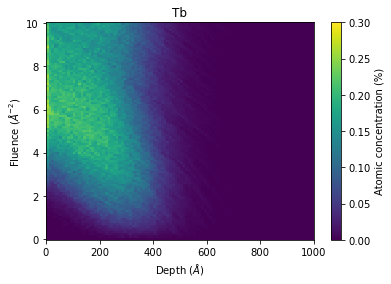

1


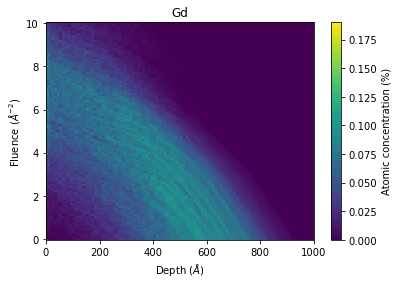

['Tbna_154_0.in', 'Tbna_154_1.in', 'Tbna_154_2.in', 'Tbna_154_3.in', 'Tbna_154_4.in', 'Tbna_154_5.in', 'Tbna_154_6.in', 'Tbna_154_7.in', 'Tbna_154_8.in', 'Tbna_154_9.in']
0


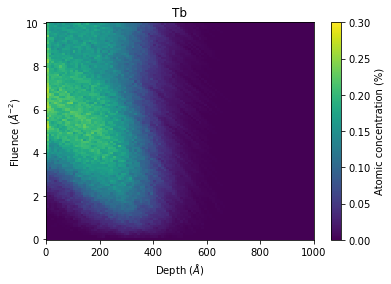

1


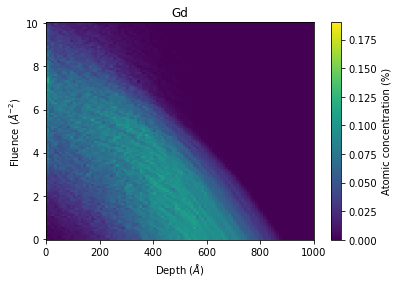

['Tbna_174_0.in', 'Tbna_174_1.in', 'Tbna_174_2.in', 'Tbna_174_3.in', 'Tbna_174_4.in', 'Tbna_174_5.in', 'Tbna_174_6.in', 'Tbna_174_7.in', 'Tbna_174_8.in', 'Tbna_174_9.in']
0


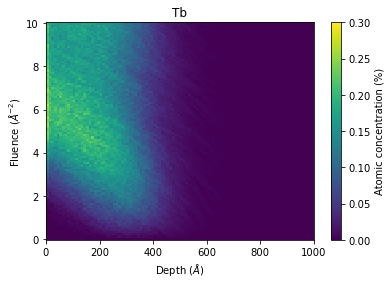

1


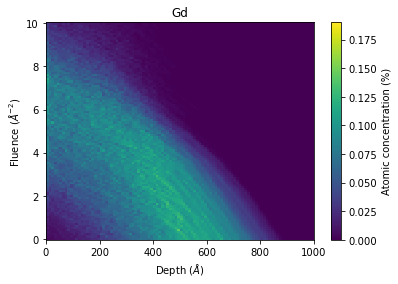

['Tbna_195_0.in', 'Tbna_195_1.in', 'Tbna_195_2.in', 'Tbna_195_3.in', 'Tbna_195_4.in', 'Tbna_195_5.in', 'Tbna_195_6.in', 'Tbna_195_7.in', 'Tbna_195_8.in', 'Tbna_195_9.in']
0


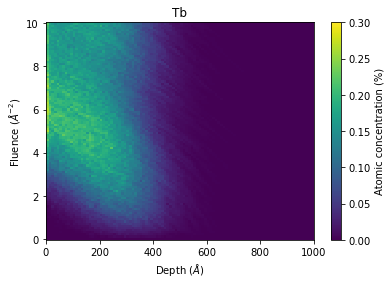

1


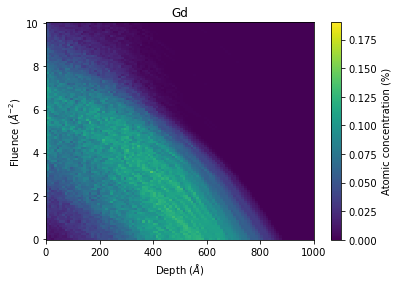

['Tbna_215_0.in', 'Tbna_215_1.in', 'Tbna_215_2.in', 'Tbna_215_3.in', 'Tbna_215_4.in', 'Tbna_215_5.in', 'Tbna_215_6.in', 'Tbna_215_7.in', 'Tbna_215_8.in', 'Tbna_215_9.in']
0


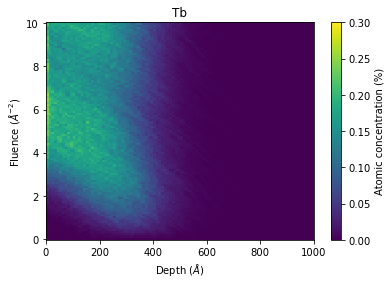

1


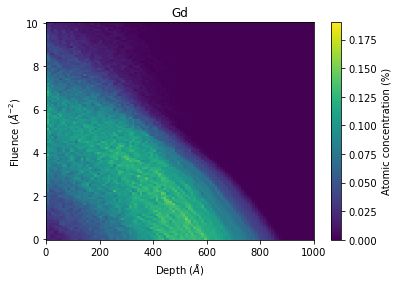

['Tbna_236_0.in', 'Tbna_236_1.in', 'Tbna_236_2.in', 'Tbna_236_3.in', 'Tbna_236_4.in', 'Tbna_236_5.in', 'Tbna_236_6.in', 'Tbna_236_7.in', 'Tbna_236_8.in', 'Tbna_236_9.in']
0


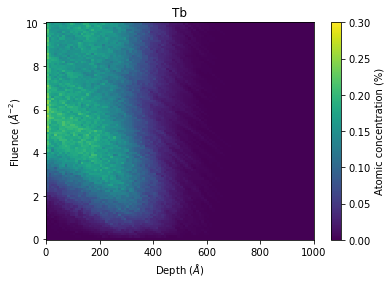

1


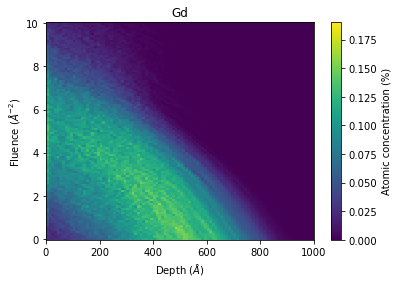

['Tbna_256_0.in', 'Tbna_256_1.in', 'Tbna_256_2.in', 'Tbna_256_3.in', 'Tbna_256_4.in', 'Tbna_256_5.in', 'Tbna_256_6.in', 'Tbna_256_7.in', 'Tbna_256_8.in', 'Tbna_256_9.in']
0


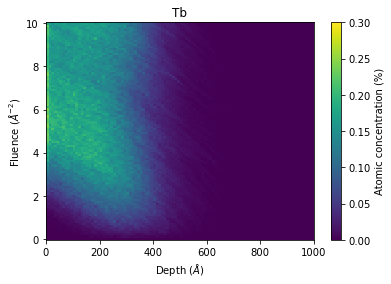

1


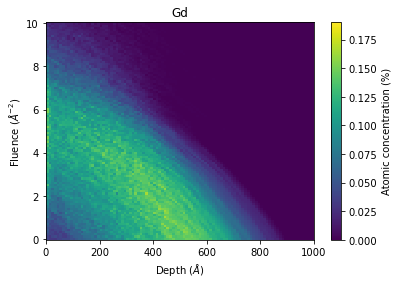

['Tbna_277_0.in', 'Tbna_277_1.in', 'Tbna_277_2.in', 'Tbna_277_3.in', 'Tbna_277_4.in', 'Tbna_277_5.in', 'Tbna_277_6.in', 'Tbna_277_7.in', 'Tbna_277_8.in', 'Tbna_277_9.in']
0


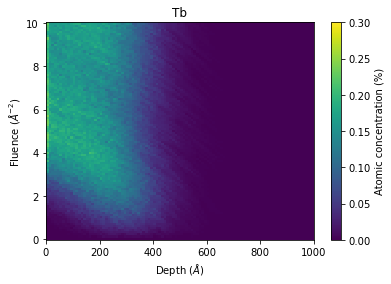

1


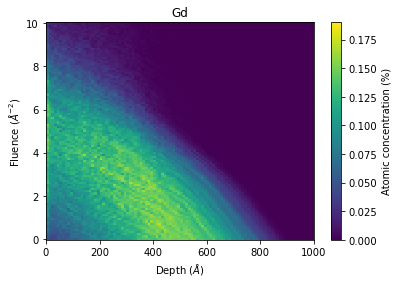

['Tbna_297_0.in', 'Tbna_297_1.in', 'Tbna_297_2.in', 'Tbna_297_3.in', 'Tbna_297_4.in', 'Tbna_297_5.in', 'Tbna_297_6.in', 'Tbna_297_7.in', 'Tbna_297_8.in', 'Tbna_297_9.in']
0


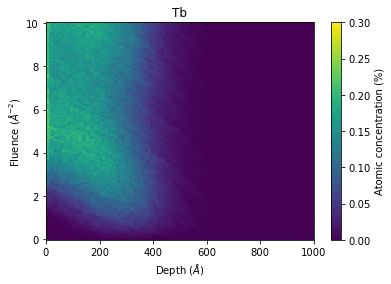

1


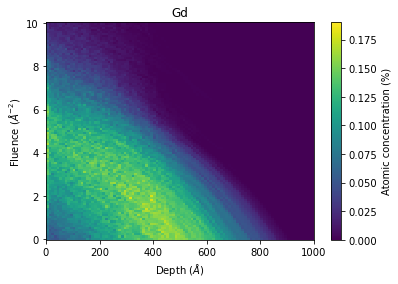

['Tbna_318_0.in', 'Tbna_318_1.in', 'Tbna_318_2.in', 'Tbna_318_3.in', 'Tbna_318_4.in', 'Tbna_318_5.in', 'Tbna_318_6.in', 'Tbna_318_7.in', 'Tbna_318_8.in', 'Tbna_318_9.in']
0


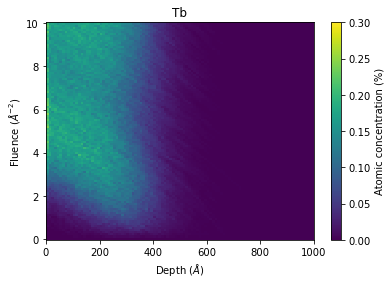

1


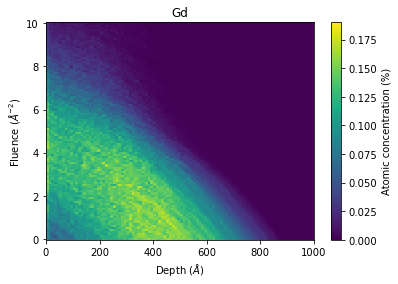

['Tbna_338_0.in', 'Tbna_338_1.in', 'Tbna_338_2.in', 'Tbna_338_3.in', 'Tbna_338_4.in', 'Tbna_338_5.in', 'Tbna_338_6.in', 'Tbna_338_7.in', 'Tbna_338_8.in', 'Tbna_338_9.in']
0


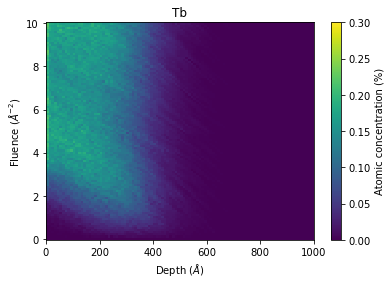

1


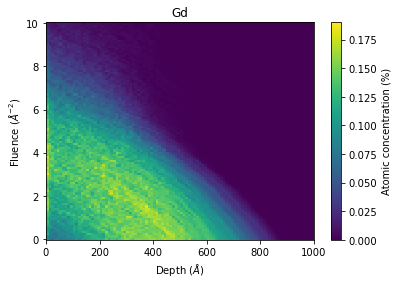

['Tbna_359_0.in', 'Tbna_359_1.in', 'Tbna_359_2.in', 'Tbna_359_3.in', 'Tbna_359_4.in', 'Tbna_359_5.in', 'Tbna_359_6.in', 'Tbna_359_7.in', 'Tbna_359_8.in', 'Tbna_359_9.in']
0


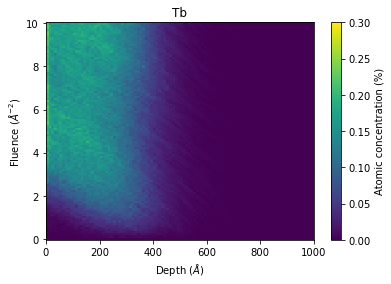

1


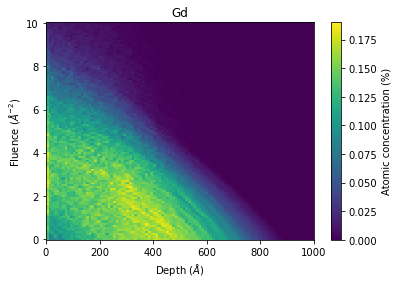

['Tbna_379_0.in', 'Tbna_379_1.in', 'Tbna_379_2.in', 'Tbna_379_3.in', 'Tbna_379_4.in', 'Tbna_379_5.in', 'Tbna_379_6.in', 'Tbna_379_7.in', 'Tbna_379_8.in', 'Tbna_379_9.in']
0


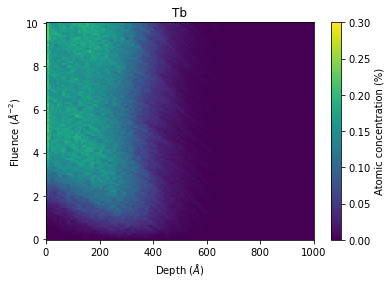

1


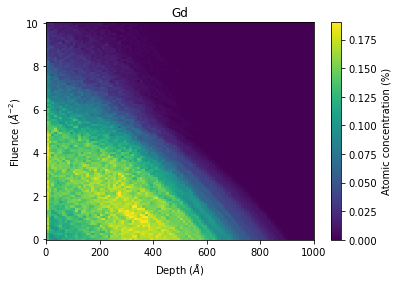

In [7]:
allmeans = []
allups = []
alldowns = []
for flGdnum in range(20): #iteration over different incoming Gd fluences
    lijst = allenamen[flGdnum*10:flGdnum*10+10]
    print(lijst)
    retainedcurves = []
    for naampje in lijst: #iteration over the different randnums
        name = naampje[0:len(naampje)-3]
        path = "C:/Users/r0750853/linux/3TRIDYN/Simulated_data/firstGdimplanted/"
        areal_dens = "Areal_density/" + name + "_ardn.dat"
        profiles = "Depth_profile/" + name + "/"
        A = TRIDYN_simulation(file_retained = path + areal_dens, file_profiles = path + profiles, aantalincomming = 2, fractions=[1,1],elementen=['Tb','Gd'])
        A.load()
        retainedcurves.append((A.retained_vals[0]))
    A.draw_3d()

For fluence of Gd = 0$\AA^{-2}$, sputtering starts at incoming fluence of Tb = 3.8
Total incoming fluence at which sputtering starts (Gd + Tb) = 3.8$\AA^{-2}$
For fluence of Gd = 0.1$\AA^{-2}$, sputtering starts at incoming fluence of Tb = 3.8
Total incoming fluence at which sputtering starts (Gd + Tb) = 3.9$\AA^{-2}$
For fluence of Gd = 0.305$\AA^{-2}$, sputtering starts at incoming fluence of Tb = 3.8
Total incoming fluence at which sputtering starts (Gd + Tb) = 4.1049999999999995$\AA^{-2}$
For fluence of Gd = 0.511$\AA^{-2}$, sputtering starts at incoming fluence of Tb = 3.7
Total incoming fluence at which sputtering starts (Gd + Tb) = 4.211$\AA^{-2}$
For fluence of Gd = 0.716$\AA^{-2}$, sputtering starts at incoming fluence of Tb = 3.7
Total incoming fluence at which sputtering starts (Gd + Tb) = 4.416$\AA^{-2}$
For fluence of Gd = 0.921$\AA^{-2}$, sputtering starts at incoming fluence of Tb = 3.6
Total incoming fluence at which sputtering starts (Gd + Tb) = 4.521$\AA^{-2}$
For flu

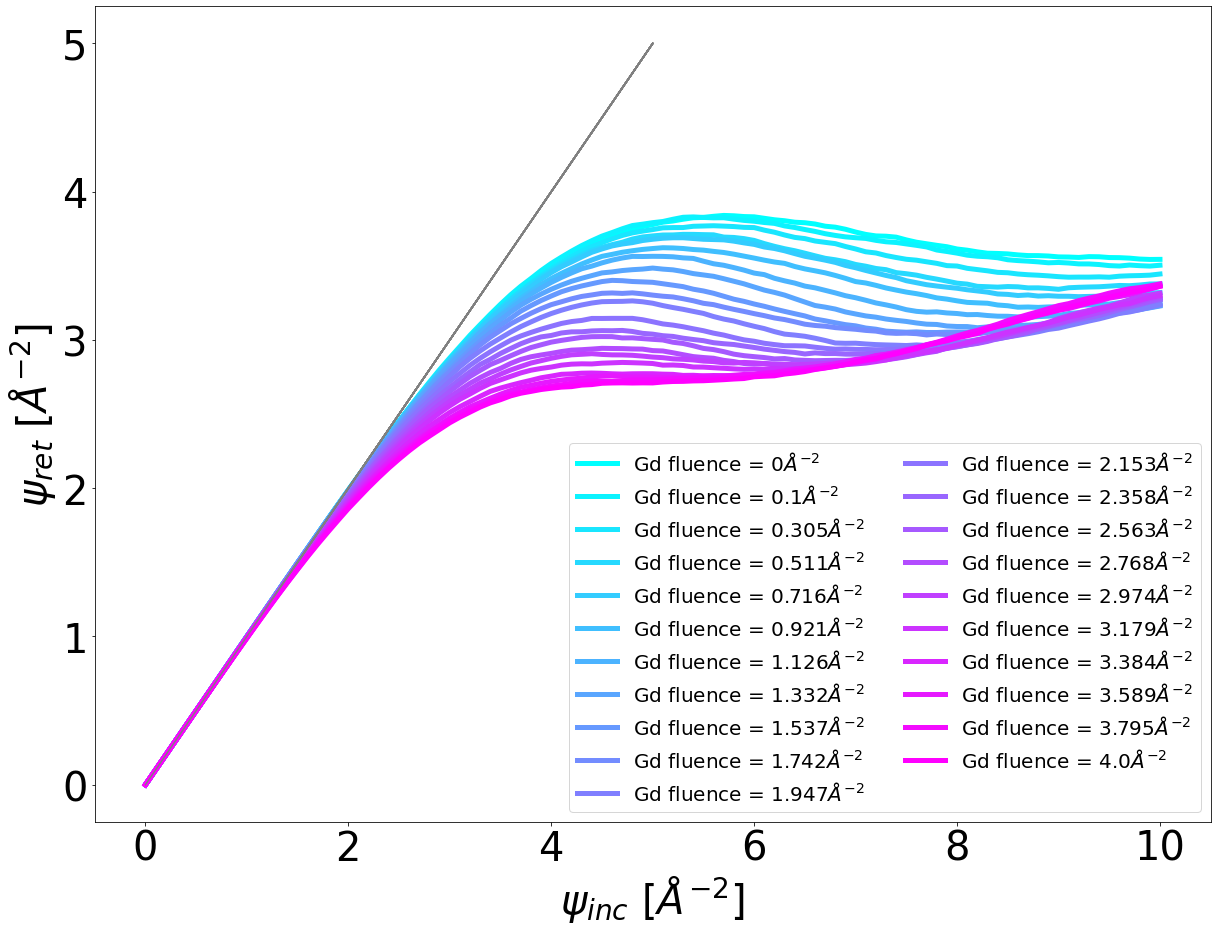

In [9]:
fluGd = [0, 0.1, 0.305, 0.511, 0.716, 0.921,
       1.126, 1.332, 1.537, 1.742, 1.947,
       2.153, 2.358, 2.563, 2.768, 2.974,
       3.179, 3.384, 3.589, 3.795, 4. ]
plt.rcParams.update({'font.size': 40})
allmeans = []
allups = []
alldowns = []
counter = -1
startall = []
startdown = []
startup = []
allerrors = []
for flGdnum in range(21): #iteration over different incoming Gd fluences
    counter+=1
    lijst = allenamen[flGdnum*10:flGdnum*10+10]
    #print(lijst)
    retainedcurves = []
    for naampje in lijst: #iteration over the different randnums
        name = naampje[0:len(naampje)-3]
        path = "C:/Users/r0750853/linux/3TRIDYN/Simulated_data/firstGdimplanted/"
        areal_dens = "Areal_density/" + name + "_ardn.dat"
        profiles = "Depth_profile/" + name + "/"
        A = TRIDYN_simulation(file_retained = path + areal_dens, file_profiles = path + profiles, aantalincomming = 2,elementen=['Tb','Gd'])
        A.load()
        retainedcurves.append((A.retained_vals[0]))
    retainedcurves=np.array(retainedcurves)
    influ = A.fluence_vals #all is Tb
    means = []
    stdevup = []
    stdevdown = []
    for ii in range(101):
        retwaarden = retainedcurves[:,ii]
        means.append(np.mean(retwaarden))
        gesort  = np.sort(retwaarden)
        stdevdown.append(gesort[1])
        stdevup.append(gesort[7])
    plt.rcParams['figure.figsize'] = [20, 15]
    plt.plot(influ,means,lw=5,label='Gd fluence = ' + str(fluGd[counter])+ '$\AA^{-2}$',color = cmap(np.linspace(0,1,21)[counter]))
    flst = []
    flstup = []
    flstdown = []
    for ii in range(len(means)):
        if 0.9*influ[ii]>means[ii]:
            flst.append(influ[ii])
        if 0.9*influ[ii]>means[ii]+(-means[ii]+stdevup[ii])/np.sqrt(10):
            flstup.append(influ[ii])
        if 0.9*influ[ii]>means[ii]-(means[ii]-stdevdown[ii])/np.sqrt(10):
            flstdown.append(influ[ii])
    startall.append(min(flst)+fluGd[counter])
    startup.append(min(flstup)+fluGd[counter])
    startdown.append(min(flstdown)+fluGd[counter])
    print('For fluence of Gd = '+str(fluGd[counter])+ '$\AA^{-2}$'+', sputtering starts at incoming fluence of Tb = ' +str(min(flst)))
    print('Total incoming fluence at which sputtering starts (Gd + Tb) = ' +str(fluGd[counter]+min(flst))+ '$\AA^{-2}$')
    #if flGdnum == 19:
    #    plt.fill_between(influ,stdevdown,stdevup,color = 'skyblue',label='1 $\sigma$ of the retained fluence')
    #else:
    #    plt.fill_between(influ,stdevdown,stdevup,color = 'skyblue')
    plt.plot(np.linspace(0,5,10),np.linspace(0,5,10),'gray')
    plt.ylabel('$\psi_{ret}$ [$\AA^{-2}$]')
    plt.xlabel('$\psi_{inc}$ [$\AA^{-2}$]')
    plt.rcParams.update({'font.size': 20})
    plt.legend(ncol=2, loc='lower right')
    plt.rcParams.update({'font.size': 40})
    allmeans.append(means[-1])
    allups.append(stdevup[-1])
    alldowns.append(stdevdown[-1])
    error1 = [abs(startall[-1]-startup[-1]),abs(startall[-1]-startdown[-1])]
    error1 = np.array(error1)
    error2 = (influ[1]-influ[0])/2
    errortot = np.sqrt(error1**2 + error2**2)
    allerrors.append(errortot)
    #allmeans.append(means[-1]*2*np.pi*0.934*0.816*10**(14)*1.5*10**(-6)*10**(-6))
    #allups.append(stdevup[-1]*2*np.pi*0.934*0.816*10**(14)*1.5*10**(-6)*10**(-6))
    #alldowns.append(stdevdown[-1]*2*np.pi*0.934*0.816*10**(14)*1.5*10**(-6)*10**(-6))
#plt.title('Retained fluence for different incoming Gd fluences\n (mean value over 10 different random seeds)')
#plt.savefig('C:/Users/r0750853/Documents/priorGdfig.pdf', dpi=500,bbox_inches = 'tight',facecolor='white')


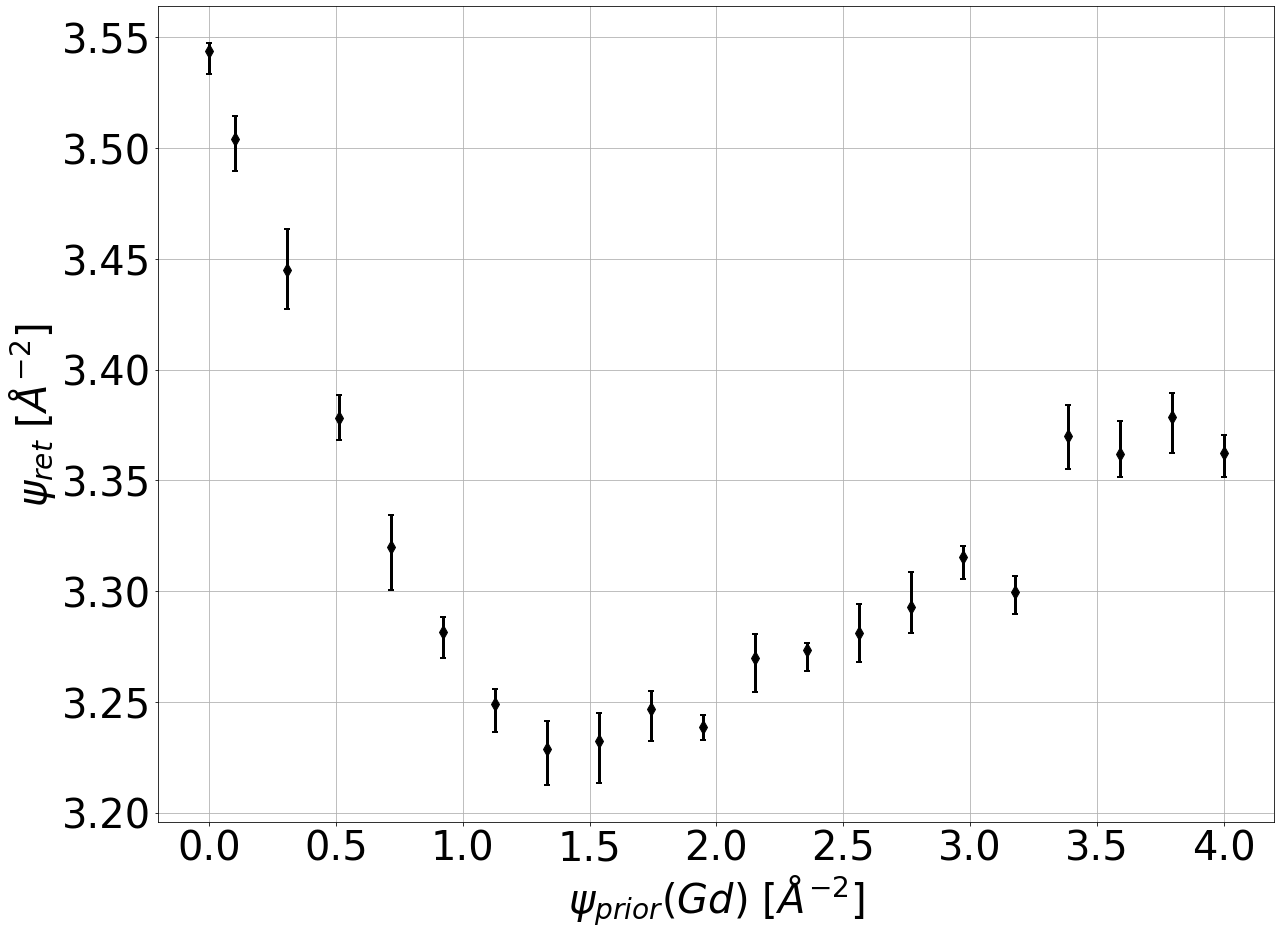

In [15]:
plt.rcParams.update({'font.size': 40})
plt.errorbar(np.append(0,np.linspace(0.1,4,20)),allmeans,yerr = [(np.array(allmeans)-np.array(alldowns))/np.sqrt(10),(np.array(allups)-np.array(allmeans))/np.sqrt(10)],  markersize=10, fmt="d", color="k",
             ecolor="k", capsize=3, capthick=2, linewidth=3)
plt.xlabel('$\psi_{prior}(Gd)$ [$\AA^{-2}$]')
#plt.ylabel('Retained activity [MBq]')
plt.ylabel('$\psi_{ret}$ [$\AA^{-2}$]')
plt.grid()
plt.savefig('C:/Users/r0750853/Documents/effectofGdprior.pdf', dpi=500,bbox_inches = 'tight',facecolor='white')

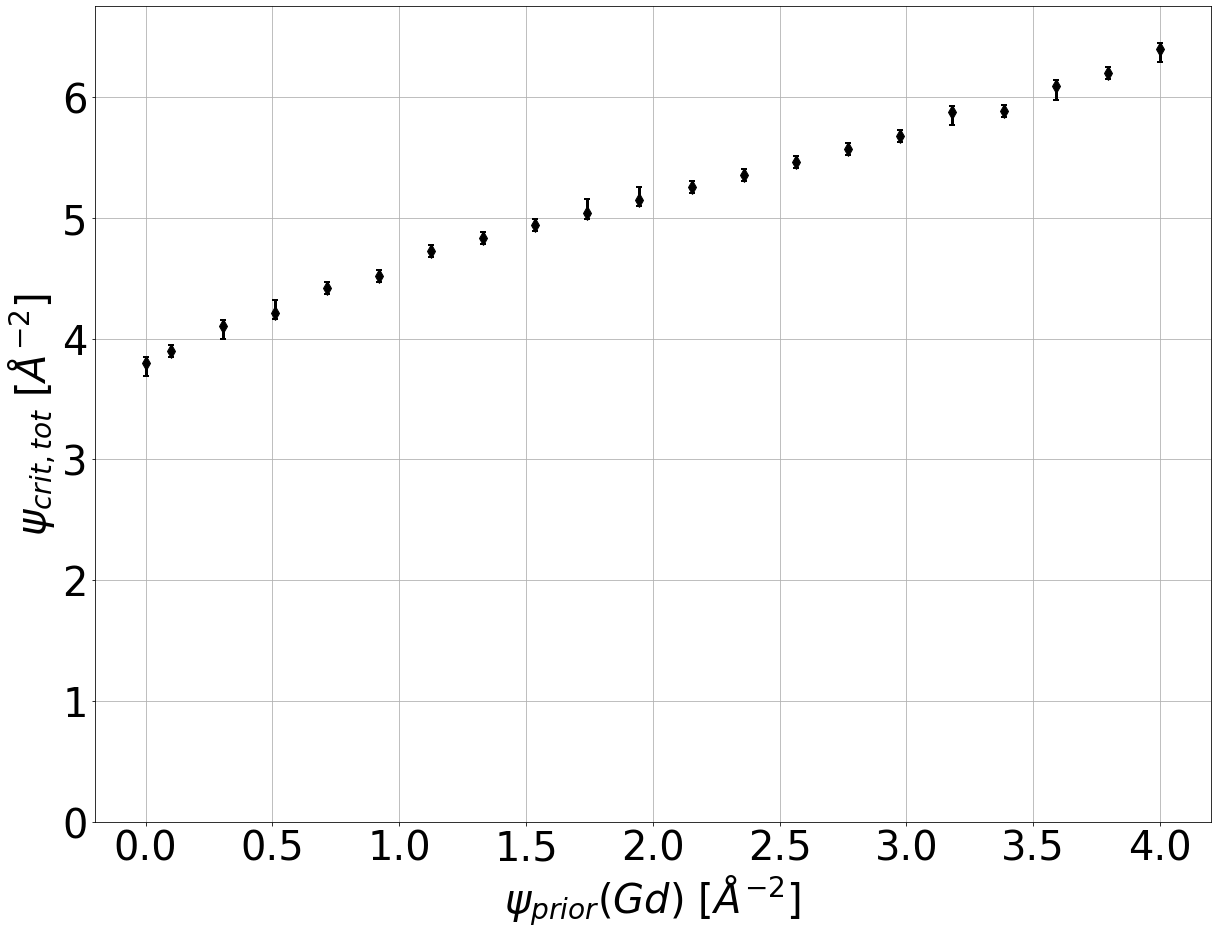

In [13]:
plt.rcParams.update({'font.size': 40})
plt.errorbar(np.append(0,np.linspace(0.1,4,20)),startall,yerr = [(np.array(allerrors))[:,1],(np.array(allerrors))[:,0]], markersize=10, fmt="d", color="k",
             ecolor="k", capsize=3, capthick=2, linewidth=3)

plt.xlabel('$\psi_{prior}(Gd)$ [$\AA^{-2}$]')
plt.ylabel('$\psi_{crit, tot}$ [$\AA^{-2}$]')
plt.ylim(0,6.75)
plt.grid()

plt.savefig('C:/Users/r0750853/Documents/effectofGdpriortotflu.pdf', dpi=500,bbox_inches = 'tight',facecolor='white')